# Практикум по стохастическому анализу. Часть №2

Выполнил \
Пилюшенок Артур \
студент 415 группы ВМК МГУ

In [2]:
import numpy as np                              # matrix calculations
from matplotlib import pyplot as plt            # plotting
from time import time                           # time of calculations

# empirical cumulative distribution function, distributions and quantiles
from scipy.stats import ecdf, norm, poisson, t, f, probplot, chi2

# for integral
from itertools import combinations_with_replacement
from scipy.special import factorial

In [3]:
def rand_expo(l, *args):
    '''
    Exponential distribution generator
    returns tensor with given shapes
    l - parameter, must be positive
    args consists of positive integer numbers (resulting dimensions)
    dimension error handling in np.random.rand
    '''
    if not l > 0:
        raise ValueError('Parameter of exponential distribution must be a positive float number.')
    return -np.log(np.random.rand(*args)) / l

In [36]:
def rand_norm(loc, scale, *args):
    '''
    Standard normal distribution generator, derivative of rand_expo
    returns tensor with given shapes
    shapes error handling in rand_expo
    '''
    omega = rand_expo(0.5, *args)
    alpha = 2 * np.pi * np.random.rand(*args)
    return loc + scale * np.sqrt(omega) * np.cos(alpha)

def rand_norm_pair(*args):
    '''
    Standard normal distribution generator, derivative of rand_expo
    returns pair of tensors with given shapes
    shapes error handling in rand_expo
    '''
    omega = rand_expo(0.5, *args)
    alpha = 2 * np.pi * np.random.rand(*args)
    return np.array((np.sqrt(omega) * np.cos(alpha), np.sqrt(omega) * np.sin(alpha)))

## Задание 7

### Условие
1. Методом случайного поиска найти минимальное значение функции $f$ на множестве $A = \{(x_1,x_2):~x_1^2+x_2^2\leqslant 1\}$, где
$$
f(x_1,x_2) = x_1^3\sin\frac{1}{x_1} + 10x_1x_2^4\cos\frac{1}{x_2},\quad x_1,x_2\neq0.
$$
При $x_1=0$ или $x_2=0$ функция доопределяется по непрерывности.

2. Методом имитации отжига найти минимальное значение функции Розенброка $g$ в пространстве $\mathbb{R}^2$, где
$$
g(x) = (x_1-1)^2 + 100(x_2-x_1^2)^2.
$$

3. Оценить точность и сравнить результаты со стандартными методами оптимизации.

### Метод случайного поиска

Метод случайного поиска минимального значения функции $f(x)$ на множестве $A$:
1. Смоделировать выборку размера $n$ точек $x\sim\mathrm{U}\{A\}$ (равномерно распределены на множестве A)
2. Выбрать ту реализацию случайной величины, на которой достигается наименьшее значение.

По условию задачи множество $A$ - круг единичного радиуса на плоскости $(x_1,x_2)$. Пусть $x=(x_1,x_2)\sim\mathrm{U}(A)$. По определению для любого борелевского множества $M$ выполняется ($\mu$ - мера Лебега на плоскости)
$$
\mathbb{P}\left( (x_1,x_2)\in M \right) = \dfrac{\mu (M)}{\mu (A)} = \dfrac{1}{\pi}\iint\limits_M dt_1dt_2 = \begin{vmatrix}
t_1 = r\cos\alpha \\
t_2 = r\sin\alpha
\end{vmatrix} = \dfrac{1}{\pi}\iint\limits_M rdrd\alpha = \iint\limits_M d(r^2)d\left(\frac{\alpha}{2\pi}\right).
$$

Следовательно, будем моделировать
$$
\begin{cases}
x_1 = \sqrt{\omega}\cos\alpha \\
x_2 = \sqrt{\omega}\sin\alpha
\end{cases}
$$
где $\omega\sim\mathrm{U}[0,1], \alpha\sim\mathrm{U}[0,2\pi]$.


Данная функция $f(x)=x_1^3\sin\frac{1}{x_1}+10x_1x_2^4\cos\frac{1}{x_2}$ обладает свойствами 
1. $f(x_1,-x_2)=f(x_1,x_2)$ (чётность по $x_2$)
2. $f(-x_1,0)=f(x_1,0)=x_1^3\sin\frac{1}{x_1}$
3. $f(0,0)=0$

Следовательно, если $x^*=(x_1^*,x_2^*)$ доставляет минимум функции, то $(x_1^*,-x_2^*)$ также доставляет минимум. \
Минимум меньше нуля, ведь $f(0.1, 0.1) < 0$ (проверяется численно). \
Следовательно, функция $f$ имеет хотя бы две точки глобального минимума.

Отметим, что при реализации метода случайного поиска значения $x_1=0, x_2=0$ достигаются с нулевой вероятностью. Следовательно, при вычислении значения заданной функции в точках выборки можно не обрабатывать неопределенность.

<!-- Пусть $\varepsilon>0$ - наперед заданная точность вычислений.  -->
Пусть $x^*=(x_1^*,x_2^*)$ доставляет минимум функции $f(x_1,x_2)$. \
Оценим точность работы алгоритма при помощи многомерной теоремы Лагранжа
$$
|f(x) - f(x^*)| \leqslant \max\limits_A 
\sqrt{\left(\dfrac{\partial f}{\partial x_1}\right)^2 + \left(\dfrac{\partial f}{\partial x_2}\right)^2} \cdot || x - x^* ||.
$$

Справедливы следующие оценки
$$
\begin{aligned}
\left|\dfrac{\partial f}{\partial x_1}\right| &= \left| 3x_1^2\sin\frac{1}{x_1} - x_1\cos\frac{1}{x_1} + 10x_2^4\cos\frac{1}{x_2}  \right| \leqslant 14. \\
\left|\dfrac{\partial f}{\partial x_2}\right| &= \left| 40x_1x_2^3\cos\frac{1}{x_2} + 10x_1x_2^2\sin\frac{1}{x_2} \right| \leqslant 50.
\end{aligned}
$$

Далее выберем окрестность радиуса $\delta\in(0,1)$: $B_\delta(x^*)=\{ x: ||x-x^*||\leqslant \delta \}$. \
Пусть $p$ - вероятность того, что в $B_\delta(x^*) \cap A$ находится хотя бы одна точка выборки $(x_1,x_2,\dots,x_n)$.
$$
p = \mathbb{P}(\exists k:~||x_k-x||\leqslant\delta) = 1 - \mathbb{P}(\forall k~ ||x_k-x^*||>\delta) = 1 - \prod_{k=1}^n\mathbb{P}(||x_k-x^*||>\delta).
$$

Если $B_\delta(x^*) \cap A = B_\delta(x^*)$, вероятность в правой части полученного выражения можно вычислить как отношение соответствующих площадей:
$$
\mathbb{P}(||x_k-x^*||>\delta) = \dfrac{\pi - \pi\delta^2}{\pi} = 1 - \delta^2 < 1 - \frac{\delta^2}{2}.
$$
Если $B_\delta(x^*) \cap A \neq B_\delta(x^*)$, то ограничим вероятность сверху числом $1-\frac{\delta^2}{2}$. Этот случай включает в себя возможное расположение точки $x^*$ на границе единичного круга. Ясно, что в худшем случае половина окрестности не будет лежать в круге.

Таким образом
$$
1-p = \prod_{k=1}^n\mathbb{P}(||x_k-x^*||>\delta) < \left(1-\frac{\delta^2}{2}\right)^n.
$$
Зафиксируем $p, \delta$. Тогда с вероятностью $p$ в окрестности радиуса $\delta$ искомого решения будет находиться элемент выборки, если размер выборки составляет
$$
n = \bigg\lfloor\dfrac{\ln(1-p)}{\ln\left(1-\frac{\delta^2}{2}\right)}\bigg\rfloor.
$$

Если выбрать $x\in B_\delta(x^*)$ погрешность вычисления составит
$$
|f(x) - f(x^*)| \leqslant \sqrt{14^2 + 50^2}\cdot\delta = \varepsilon.
$$
Таким образом, по заданным $\varepsilon$ - погрешности вычисления и $p$ - уровне доверия, можно вычислить $\delta, n$.

In [37]:
def func(x1, x2):
    return x1 ** 3 * np.sin(1 / x1) + 10 * x1 * x2 ** 4 * np.cos(1 / x2)

def min_random_search(func, eps, p):
    delta = eps / np.sqrt(2696)
    n_points = np.floor(np.log(1 - p) / np.log(1 - delta**2 / 2)).astype(int)
    omega_sample = np.random.rand(n_points)
    alpha_sample = np.random.rand(n_points) * 2 * np.pi
    x1 = np.sqrt(omega_sample) * np.cos(alpha_sample)
    x2 = np.sqrt(omega_sample) * np.sin(alpha_sample)
    f_min = np.min(func(x1, x2))
    i_min = np.argmin(func(x1, x2))
    return f_min, [x1[i_min], x2[i_min]], n_points


print(f"f(0.1,0.1) = {func(0.1,0.1):.4f} < 0.")

eps = 0.05
p = 0.99
val, point, n_points = min_random_search(func, eps, p)
print(f"f*({point[0]:.8f},{point[1]:.8f})= {val:.8f} obtained by sample of {n_points} points.")

f(0.1,0.1) = -0.0006 < 0.
f*(-0.36067847,-0.93267980)= -1.28825490 obtained by sample of 9932428 points.


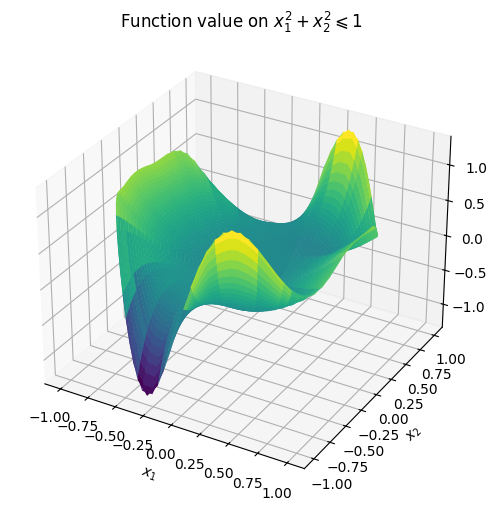

In [40]:
n_points = 100
r = np.linspace(0.001, 1, n_points)
alpha = np.linspace(-2*np.pi, 2*np.pi, n_points)
r, alpha = np.meshgrid(r, alpha)

X = r * np.sin(alpha)
Y = r * np.cos(alpha)
Z = func(X, Y)

plt.figure(figsize=(9,6))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_title('Function value on $x_1^2+x_2^2\leqslant1$')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
plt.show()

### Метод имитации отжига

In [127]:
def func_Rosenbrock(x):
    return (x[0] - 1)**2 + 100 * (x[1] - x[0]**2)**2

def choose_neighbour(s_i, T_i, sigma):
    pair = rand_norm_pair()
    return s_i + np.sqrt(sigma) * T_i * pair

def transfer_probability(d_F_i, T_i):
    return np.exp(-d_F_i * T_i)

def reduce_temperature(T_i, k):
    return k * T_i

def min_simulated_annealing(sigma,
                            k,
                            s_0,
                            T_0,
                            iter_count,
                            func,
                            choose_neighbour,
                            transfer_probability,
                            reduce_temperature):
    # always transfer at first step

    func_last = func(s_0)
    func_min = func_last
    point_min = s_0

    s_i = choose_neighbour(s_0, T_0, sigma)
    T_i = reduce_temperature(T_0, k)

    # other steps
    for i in range(iter_count):
        func_value = func(s_i)
        print(func_value)
        if func_value < func_min:
            func_min = func_value
            point_min = s_i
        transfer = transfer_probability(func_value - func_last, T_i)
        if np.random.rand() < transfer:
            s_i = choose_neighbour(s_i, T_i, sigma)
        T_i = reduce_temperature(T_i, k)

    return func_min, point_min


val, point = min_simulated_annealing(5,
                                    0.79,
                                    [1.5, 1.5],
                                    1,
                                    10000,
                                    func_Rosenbrock,
                                    choose_neighbour,
                                    transfer_probability,
                                    reduce_temperature)
print(val, point)

# T = 0.01

# s_i = [0.5, 0.5]
# T_i = T
# func_last = np.inf
# iter_count = 1000

# for i in range(iter_count):
#     func_value = func_Rosenbrock(s_i)
#     transfer = transfer_probability(func_value - func_last, T_i)
#     if np.random.rand() < transfer:
#         s_i = choose_neighbour(s_i, T_i)
#     T_i = reduce_temperature(T_i)
#     func_last = np.min([func_value, func_last])

# func_last, s_i

60.40361439552778
60.40361439552778
60.40361439552778
60.40361439552778
60.40361439552778
60.40361439552778
60.40361439552778
60.40361439552778
223.23753988413932
223.23753988413932
223.23753988413932
223.23753988413932
223.23753988413932
223.23753988413932
223.23753988413932
223.23753988413932
223.23753988413932
223.23753988413932
223.23753988413932
223.23753988413932
223.23753988413932
223.23753988413932
221.85643960248868
221.85643960248868
213.6863191470569
213.6863191470569
209.4528066343458
209.11120023325964
209.11120023325964
209.11120023325964
207.36819669013
207.36819669013
209.84721840775998
209.20350664014074
208.51185557891222
208.94219847047523
208.79609613937748
209.2957950094558
209.37738269219676
209.27111277676715
209.30001467205767
209.29334148476968
209.46996544568367
209.4623987549955
209.55017439289713
209.50357789486253
209.52985837767707
209.5705946132163
209.59251159862185
209.5925366364253
209.5574189685551
209.5515443777502
209.5559292293937
209.5727747832265

### Сравнение методов

## Задание 8

### Условие
1. Применить метод Монте-Карло к решению первой краевой задачи для двумерного уравнения Лапласа в единичном круге
$$
\begin{cases}
\Delta u = 0,(x,y)\in D \\
u\vert_{\delta D} = f(x,y) \\
u\in C^2(D), f\in C(\delta D) \\
D=\{(x,y)\in\mathbb{R}^2: x^2+y^2\leqslant 1 \}
\end{cases}
$$

2. Для функции $f(x,y) = x^2-y^2$ найти аналитическое решение и сравнить с полученным по методу Монте-Карло.

### Метод Монте-Карло для уравнения Лапласа

<!-- Будем решать задачу не в единичном круге, а в единичном квадрате. Решение при этом не изменится, ведь ($x^2-y^2$) - единственное решение поставленной задачи в единичном круге, которое является непрерывным. После работы алгоритма выберем только те точки, которые лежат в единичном круге. -->

<!-- Введём сетку на единичном квадрате $|x|\leqslant1, |y|\leqslant1$. -->

Введём равномерную квадратную сетку в единичном круге с шагом $h$. Пусть $P(x_i,y_i)$ - узел, внутренняя точка сетки (имеет 4 соседа), $Q(\tilde{x}_i,\tilde{y}_i)$ - граничная точка сетки. \
Рассмотрим соответствующую теоретико-вероятностную схему. \
Будем искать вероятность $u(P,Q)$, того, что выйдя из внутренней точки $P$, будет достигнута граничная точка $Q$. \
Считаем, что все соседи выбираются равновероятным образом. Тогда для соседних точек $P_i,i=\overline{1,4}$ по отношению к $P$ справедливо
$$
u(P,Q) = \dfrac{1}{4}\left( u(P_1,Q) + u(P_2, Q) + u(P_3, Q) + u(P_4, Q) \right).
$$

Таким образом, мы пришли к конечноразностному уравнению, которое является конечно-разностной схемой для уравнения Лапласа:
$$
u(P) = \dfrac{1}{4}\left( u(P_1) + u(P_2) + u(P_3) + u(P_4) \right),
$$
где $P$ - внутренняя, $P_i,i=\overline{1,4}$ - соседние по отношению к $P$.

Вероятности $u(P,Q)$ можно вычислять приближенно: будем моделировать $N$ раз "блуждание" из точки $P$ в точку $Q$ и считать число $M(Q)$ испытаний, при которых "блуждание" оканчивается в точке $Q$:
$$
u(P,Q)\approx \frac{M(Q)}{N}.
$$

Чтобы решить поставленную задачу Дирихле, нужно немного обобщить полученную вероятностную схему. Нужно считать, что при выходе из узла $P$ и дальнейшем посещении граничной точки $Q$ с нас взымается штраф, равный $f(Q)$. Ясно, что величина выплаченного штрафа является случайной величиной. Обозначим её $\xi(P)$.

Пусть $\{Q_1,\dots,Q_s\}$ - совокупность всех граничных точек.
Тогда величина штрафа принимает значения $\{f(Q_1),\dots,f(Q_s)\}$, вероятность заплатить $f(Q_l)$ равняется $u(P,Q_l)$.
Значит, математическое ожидание штрафа определяется как:
$$
w(P) = \mathbb{E}\xi(P) = \sum_{l=1}^{s}f(Q_l)u(P,Q_l).
$$
Причем, $P(P)$ удовлетворяет разностному уравнению
$$
P(P) = \dfrac{1}{4}\left( w(P_1) + w(P_2) + w(P_3) + w(P_4) \right).
$$
Это непосредственно проверяется из исходной конечно-разностной схемы для уравения Лапласа при $Q=Q_l$ и суммировании обеих частей уравнений.

Таким образом, $w(P)$ принимает на границе заданные значения, является решением задачи Дирихле.

In [ ]:
import itertools

def solve_Laplace(func, n_points, n_tests):

    def find_nearest():
        pass

    carthesian_grid = list(itertools.product(np.linspace(-1, 1, n_points), repeat=2))


n_points = 10 + 1
# step = 
carthesian_grid = list(itertools.product(np.linspace(-1, 1, n_points), repeat=2))

for point in test:
    x, y = point
    if (abs(x) == 1 or abs(y) == 1):
        continue
    

array(<itertools.product object at 0x000001D2D785BAC0>, dtype=object)

### Сравнение численного результата с аналитическим решением

Функция $f(x,y)=x^2-y^2$ удовлетворяет $\Delta u=0$. Для внешней задачи Дирихле условием регулярности является ограниченность функции $u$. Функция $f=u$ является ограниченной, следовательно, данное уравнение имеет единственное решение, равное $x^2-y^2$.

## Задание 9

### Условие

Рассмотреть два вида гауссовских процессов:

- Винеровский процесс $W(t), t\in[0,1], W(0)=0$.

- Процесс Орнштейна-Уленбека $X(t), t\in[0,1], X(0)=X_0$, т.е. стационарный марковский гауссовский процесс. Начальные значения $X_0$ следует выбирать случайным образом так, чтобы полученный процесс был стационарным.

Для данных процессов:

1. Найти ковариационную функцию и переходные вероятности.

2. Промоделировать независимые траектории процесса с данными переходными вероятностями методом добавления разбиения отрезка.

3. Построить график траектории, не соединяя точки ломаной, с целью получения визуально непрерывной линии.

### Ковариационные функции и переходные вероятности

__Опр.__ Рассмотрим вероятностное пространство $(\Omega,\mathcal{F},\mathbb{P})$. Случайный процесс - параметризованное семейство случайных величин $\{P_t\}_{t\in T}$, определенных на одном вероятностном пространстве, вида
$$
P_t: \Omega\mapsto \mathbb{R}\quad\forall t\in T,\quad T\subset[0,+\infty).
$$

__Опр.__ Случайный процесс $P_t$ имеет независимые приращения, если $\forall 0<t_0<t_1<t_2<\cdots<t_{n-1}<t_n,~ t_i\in T,i=\overline{0,n}$ случайные величины $P_{t_0}, P_{t_1}-P_{t_0}, P_{t_2}-P_{t_1}, \dots, P_{t_n}-P_{t_{n-1}}$ являются независимыми.

__Опр.__ Случайный процесс $P_t$ является гауссовским, если $\forall 0<t_0<t_1<t_2<\cdots<t_{n-1}<t_n,~ t_i\in T,i=\overline{0,n}$ случайный вектор $(P_{t_0},P_{t_1},\dots,P_{t_n})$ имеет многомерное нормальное распределение.

__Опр.__ Случайный процесс $P_t$ является стационарным, если его конечномерные распределения инвариантны относительно сдвига по времени.

__Опр.__ Случайный процесс $P_t$ является марковским, если 

__Опр.__ Винеровский процесс $W_t,t\in T$ - это случайный процесс, обладающий следующими свойствами:
1. $W_0 = 0$ п.н.
2. $W_t$ имеет независимые приращения: $\forall 0\leqslant s<t$ .
3. $W_{t}-W_{s} \sim \mathcal{N}(0, t-s),~\forall 0\leqslant s<t $.

Из теоремы Колмогорова вытекает ещё одно свойство: $W_t$ имеет непрерывные траектории.

### Моделирование независимых траекторий

### Графики траекторий

## Задание 10

### Условие

Произвести фильтрацию одномерного процесса Орнштейна-Уленбека:

1. Используя генетор белого шума, добавить к реализации процесса Орнштейна-Уленбека случайную ошибку с заранее известной дисперсией.

2. При помощи одномерного фильтра Калмана оценить траекторию процесса по зашумленному сигналу, считая известными параметры шума и процесса.

3. Рассмотреть следующие виды шума:
    1. Гауссов
    2. Коши (шум имеет распределение Коши)

## Задание 11

### Условие

Построить двумерное пуассоновское поле, отвечающее сложному пуассоновскому процессу:

1. Система массового обслуживания. Первая координата поля - время поступления заявки в СМО (распределение равномерно), а вторая - время обслуживания заявки (распределение $\chi^2$ с десятью степенями свободы).

2. Система массового обслуживания с циклической интенсивностью $\lambda(1+\cos(t))$ и единичными скачками. При помощи метода Льюиса и Шедлеара, свести задачу моделирования неоднородного пуассоновского процесса к моделированию двумерного пуассоновского поля, где первая координата распределена равномерно, а вторая имеет распределение Бернулли.

3. Работа страховой компании: первая координата - момент наступления страхового случая (равномерное распределение), вторая величина ущерба (распределение Парето). Поступление капитала считать линейным по времени со скоростью $c>0$, начальный капитал $W>0$.